In [349]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

2.4.1


In [350]:

import csv
time_step = []
temps = []

with open('./data/CLM_온실가스_MNH_20210515164253.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[3]))
    time_step.append(step)
    step += 1
# co2 = pd.read_csv('CLM_온실가스_MNH_20210515164253.csv', parse_dates=True)
# co2 = co2.dropna()
series_decompose = seasonal_decompose(np.array(temps), model='additive', freq=13, )
# print(series_decompose.trend)
series_resid = np.nan_to_num(series_decompose.resid, copy=False)
series_trend = np.nan_to_num(series_decompose.trend, copy=False)
series_seasonal= np.nan_to_num(series_decompose.seasonal, copy=False)
time = np.array(time_step)
# plot_series(time, series_resid)
# plot_series(time, series_trend)
# plot_series(time, series_seasonal)

<ipython-input-350-04e9224edb76>:15: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  series_decompose = seasonal_decompose(np.array(temps), model='additive', freq=13, )


In [351]:



def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    print(ds)
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(4).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [352]:
split_time = int(len(series_resid)*8/10)
time_train_r = time[:split_time]
x_train_r = series_resid[:split_time]
time_valid_r = time[split_time:]
x_valid_r = series_resid[split_time:]

window_size = 5
batch_size = 32
shuffle_buffer_size = 300
train_set = windowed_dataset(x_train_r, window_size, batch_size, shuffle_buffer_size)
print(x_train_r.shape)
tf.random.set_seed(42)
np.random.seed(42)

<MapDataset shapes: ((None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(197,)


Epoch 1/100
6/6 [==============================] - 4s 8ms/step - loss: 3.2520 - mae: 3.7252
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 3.2072 - mae: 3.6793
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 3.2131 - mae: 3.6827
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 3.1642 - mae: 3.6324
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 3.2763 - mae: 3.7453
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 3.1530 - mae: 3.6175
Epoch 7/100
6/6 [==============================] - 0s 6ms/

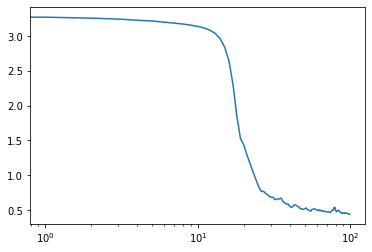

In [353]:
model_series_resid = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model_series_resid.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model_series_resid.fit(train_set,epochs=100)

plt.semilogx(history.history["loss"])

[-0.22636104 -5.3291373  -7.649331   -5.9946637  -2.1057444   0.7197506
  2.391524    3.4848912   3.836651    3.8479803   3.6029115   1.8193305
 -1.6176035  -5.9196644  -8.164811   -5.401513   -1.2012513   1.0608199
  2.792524    3.916097    3.3731053   3.513131    3.3293507   1.7218144
 -1.8662429  -5.6444273  -7.4417706  -4.832923   -0.93434954  1.5493631
  4.049619    5.3298116   2.0085726  -6.7576857  -8.807268   -3.3646665
  0.22310722  1.54773     2.240289    3.3050163   4.741724    5.336286
  4.85248    -0.6497896  -5.6208034  -0.56442     0.49175572  0.94589645
  0.19040632  0.02520931]


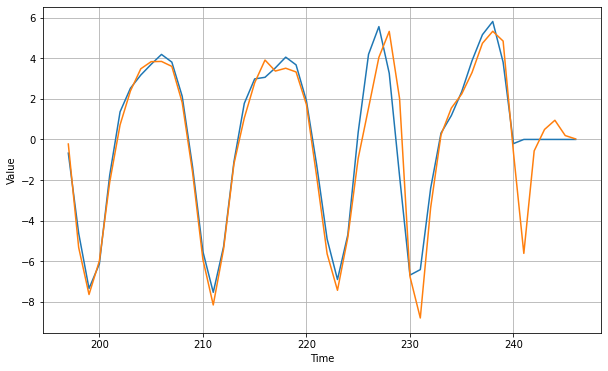

In [354]:
rnn_forecast_r = model_forecast(model_series_resid, series_resid[..., np.newaxis], window_size)
rnn_forecast_r = rnn_forecast_r[split_time - window_size:-1, -1, 0]
print(rnn_forecast_r)
plt.figure(figsize=(10, 6))
plot_series(time_valid_r, x_valid_r)
plot_series(time_valid_r, rnn_forecast_r)

In [355]:
split_time_t = int(len(series_trend)*8/10)
time_train_t = time[:split_time]
x_train_t = series_trend[:split_time]
time_valid_t = time[split_time:]
x_valid_t = series_trend[split_time:]

window_size = 3
batch_size = 32
shuffle_buffer_size = 300
train_set = windowed_dataset(x_train_t, window_size, batch_size, shuffle_buffer_size)
print(x_train_t.shape)
tf.random.set_seed(42)
np.random.seed(42)

<MapDataset shapes: ((None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(197,)


Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 129.8767 - mae: 130.3711
Epoch 2/100
7/7 [==============================] - 0s 834us/step - loss: 122.4676 - mae: 122.9610
Epoch 3/100
7/7 [==============================] - 0s 834us/step - loss: 108.3919 - mae: 108.8721
Epoch 4/100
7/7 [==============================] - 0s 834us/step - loss: 95.6950 - mae: 96.1856
Epoch 5/100
7/7 [==============================] - 0s 834us/step - loss: 80.4720 - mae: 80.9653
Epoch 6/100
7/7 [==============================] - 0s 833us/step - loss: 62.8293 - mae: 63.3204
Epoch 7/100


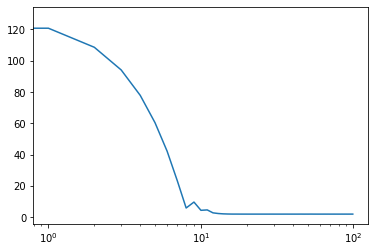

In [356]:
model_series_trend = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model_series_trend.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model_series_trend.fit(train_set,epochs=100)

plt.semilogx(history.history["loss"])

[4.0706808e+02 4.0742224e+02 4.0769937e+02 4.0794574e+02 4.0821518e+02
 4.0849234e+02 4.0862320e+02 4.0855392e+02 4.0841537e+02 4.0842307e+02
 4.0881567e+02 4.0943158e+02 4.0991660e+02 4.1023990e+02 4.1047858e+02
 4.1071725e+02 4.1097897e+02 4.1117917e+02 4.1125613e+02 4.1120227e+02
 4.1111758e+02 4.1116379e+02 4.1147171e+02 4.1193365e+02 4.1234164e+02
 4.1264188e+02 4.1271353e+02 4.1245947e+02 4.1187897e+02 4.1134396e+02
 4.1118069e+02 4.1137009e+02 4.1185590e+02 4.1270273e+02 4.1384985e+02
 4.1500467e+02 4.1590540e+02 4.1639807e+02 4.1648279e+02 4.1644199e+02
 4.1656516e+02 4.1701477e+02 4.1758060e+02 4.1797476e+02 4.1824731e+02
 1.1444192e-03 1.1444192e-03 1.1444192e-03 1.1444192e-03 1.1444192e-03]


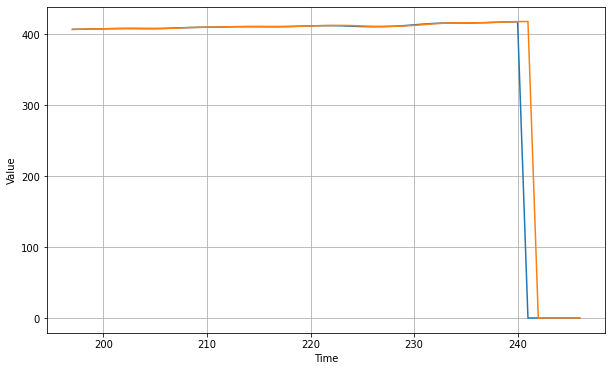

In [357]:
rnn_forecast_t = model_forecast(model_series_trend, series_trend[..., np.newaxis], window_size)
rnn_forecast_t = rnn_forecast_t[split_time - window_size:-1, -1, 0]
print(rnn_forecast_t)
plt.figure(figsize=(10, 6))
plot_series(time_valid_t, x_valid_t)
plot_series(time_valid_t, rnn_forecast_t)

In [358]:
split_time = int(len(series_seasonal)*8/10)
time_train_s = time[:split_time]
x_train_s = series_seasonal[:split_time]
time_valid_s = time[split_time:]
x_valid_s = series_seasonal[split_time:]

window_size = 5
batch_size = 32
shuffle_buffer_size = 300
train_set = windowed_dataset(x_train_s, window_size, batch_size, shuffle_buffer_size)
print(x_train_s.shape)
tf.random.set_seed(42)
np.random.seed(42)

<MapDataset shapes: ((None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(197,)


Epoch 1/100
6/6 [==============================] - 2s 7ms/step - loss: 0.3273 - mae: 0.7301
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3304 - mae: 0.7365
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3213 - mae: 0.7245
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3275 - mae: 0.7315
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3193 - mae: 0.7198
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3184 - mae: 0.7169
Epoch 7/100
6/6 [==============================] - 0s 6ms/

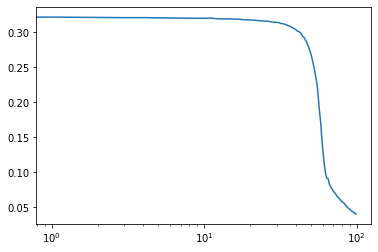

In [359]:
model_series_seasonal = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model_series_seasonal.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model_series_seasonal.fit(train_set,epochs=100)

plt.semilogx(history.history["loss"])


[-0.33336955 -0.9253898  -1.1193278  -1.110956   -0.8721306  -0.57938373
 -0.26186013  0.14386004  0.63757867  1.1208031   1.2568865   1.1764088
  0.5327357  -0.33336955 -0.9253898  -1.1193278  -1.110956   -0.8721306
 -0.57938373 -0.26186007  0.14386007  0.63757867  1.1208031   1.2568865
  1.1764088   0.5327357  -0.33336955 -0.92538995 -1.1193278  -1.110956
 -0.8721306  -0.5793837  -0.26186013  0.14386007  0.63757867  1.1208029
  1.2568865   1.1764088   0.5327357  -0.3333698  -0.9253898  -1.1193278
 -1.110956   -0.8721306  -0.57938373 -0.26186013  0.14386007  0.6375786
  1.1208031   1.2568865 ]


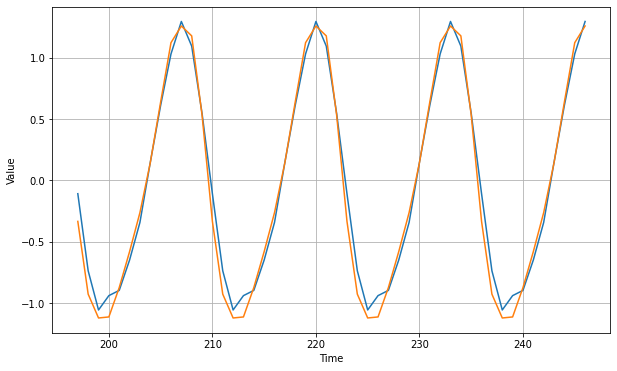

In [360]:
rnn_forecast_s = model_forecast(model_series_seasonal, series_seasonal[..., np.newaxis], window_size)
rnn_forecast_s = rnn_forecast_s[split_time - window_size:-1, -1, 0]
print(rnn_forecast_s)
plt.figure(figsize=(10, 6))
plot_series(time_valid_s, x_valid_s)
plot_series(time_valid_s, rnn_forecast_s)

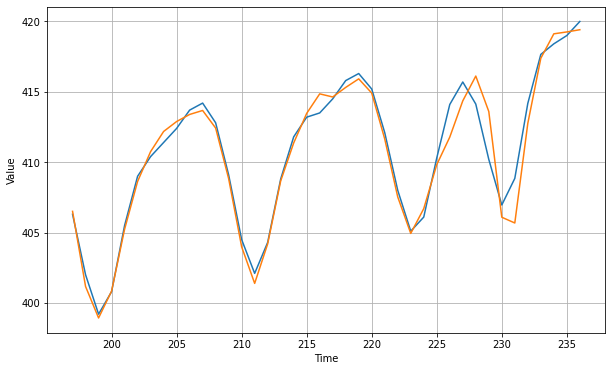

In [362]:
plt.figure(figsize=(10, 6))
plot_series(time_valid_s[:-10], x_valid_s[:-10]+x_valid_t[:-10]+x_valid_r[:-10])
plot_series(time_valid_s[:-10], rnn_forecast_s[:-10]+rnn_forecast_t[:-10]+rnn_forecast_r[:-10])